In [ ]:
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import os
import sys

In [ ]:
cwd = os.getcwd()
print(cwd)
dataPath = os.path.join(cwd, 'data')
austin_housing = pd.read_csv(os.path.join(dataPath, 'crime-housing-austin-2015.csv'))
zip_codes = pd.read_csv(os.path.join(dataPath, 'AustinZipCodes.csv'))

In [ ]:
austin_housing.head()
austin_housing.columns

In [ ]:
zip_codes.head()
zip_codes.columns

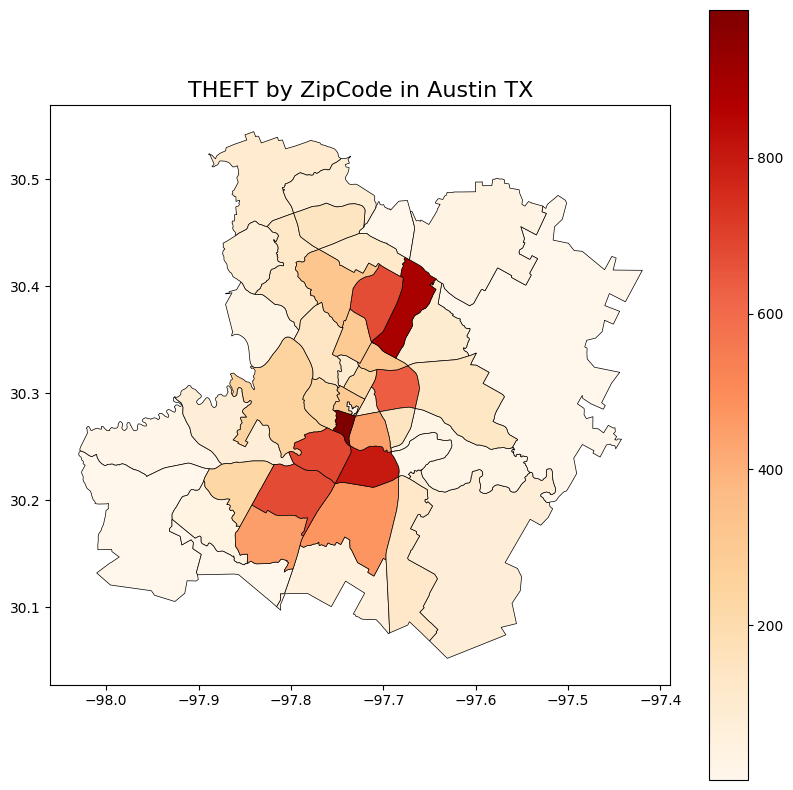

In [25]:
""" 
Karl's Spatial Analysis 
"""
import geopandas as gpd

df = austin_housing.copy()
# Date format: 01-Jan-15.  d=day, b=abbreviated month,y=2-digit year
# df['Report_Date'] = pd.to_datetime(df['Report_Date'], format='%d-%b-%y')

# Aggregate crimes by zip code
crime_zip = df[['Zip_Code_Crime', 'Highest_Offense_Desc']].copy()
crime_zip.dropna(inplace=True)
crime_zip.groupby(['Zip_Code_Crime', 'Highest_Offense_Desc']).count()
crime_zip['Total_Crime'] = crime_zip.groupby(['Zip_Code_Crime', 'Highest_Offense_Desc'])['Highest_Offense_Desc'].transform('count')
crime_zip['Zip_Code_Crime'] = crime_zip['Zip_Code_Crime'].astype('int64')
crime_zip['Zip_Code_Crime'] = crime_zip['Zip_Code_Crime'].astype('str')
# print(crime_zip.columns)
# print(crime_zip.head(5))

# Create a df with the number of THEFTS per zip code. Drop duplicates (dunno y there are duplicates)
theft_by_zip = crime_zip[crime_zip['Highest_Offense_Desc'] == 'THEFT'].copy().reset_index(drop=True)
theft_by_zip.drop(columns=['Highest_Offense_Desc'], inplace=True)
theft_by_zip.drop_duplicates(inplace=True)

""" 
Map of Austin TX  
https://openaustin.carto.com/u/oa-admin/tables/austin_area_zip_codes/public?redirected=true 
"""
# Load the GeoDataFrame
austinMap = gpd.read_file(os.path.join(dataPath, 'austin_area_zip_codes.geojson'))
austinMap['zipcode'] = austinMap['zipcode'].astype('str')

# Merge THEFT counts with austinMap
austinMap = austinMap.merge(theft_by_zip, left_on='zipcode', right_on='Zip_Code_Crime', how='left')
# Save GEOJSON file to look at data
# austinMap.to_file(os.path.join(dataPath, 'austinMap.geojson'), driver='GeoJSON')

# Plot the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
austinMap.plot(ax=ax, column='Total_Crime', cmap='OrRd', linewidth=0.5, edgecolor='black', legend=True)
ax.set_title('THEFT by ZipCode in Austin TX', fontsize=16)
plt.show()